In [3]:
import os

config = {}
config["weights_file"] = os.getcwd() + '/model/weight'
config["patch_size"] = (64, 64, 64)  # switch to None to train on the whole image
config["patch_gap"] = 16
config["batch_size"] = 10
config["kfold"] = 5

config["input_shape"] = (1, None, None, None)
config["depth"] = 4 # depth of layers for V/Unet
config["n_base_filters"] = 32
config["pool_size"] = (2, 2, 2)  # pool size for the max pooling operations
config["deconvolution"] = True  # if False, will use upsampling instead of deconvolution

config["patience"] = 10  # learning rate will be reduced after this many epochs if the validation loss is not improving
config["early_stop"] = 10  # training will be stopped after this many epochs without the validation loss improving
config["initial_learning_rate"] = 0.00001
config["learning_rate_drop"] = 0.5  # factor by which the learning rate will be reduced
config["n_epochs"] = 1

In [4]:
from model.data import *
from model.model import *

d = Data()
d.load_data(config["patch_size"])

# prepare data for training
train_num, valid_num = d.prekfold(config["patch_size"], config["patch_gap"], config["batch_size"], config["kfold"])

Using TensorFlow backend.


In [28]:
from model.recon import *

weight_path = ['/model/weight/ref/weights-02-0.02-0429-binary-patch.hdf5',
              ]
weight_name = ['binary',
              ]

for i_weight in range(len(weight_path)):

    model = unet_model_3d(input_shape=config["input_shape"],
                                  pool_size=config["pool_size"],
                                  initial_learning_rate=config["initial_learning_rate"],
                                  deconvolution=config["deconvolution"],
                                  depth=config["depth"],
                                  n_base_filters=config["n_base_filters"])
    model.load_weights(os.getcwd() + weight_path[i_weight]) 
    
    fold_index = 0
    for i in d.valid_index:
        j = d.valid_index[i][fold_index]
        recons = Reconstruct(j, d.data[i][j][0].shape, config["patch_size"], True)
        normal = Reconstruct(j, d.data[i][j][0].shape, config["patch_size"], False)
        image = Reconstruct(j, d.data[i][j][0].shape, config["patch_size"], False)
        target = Reconstruct(j, d.data[i][j][0].shape, config["patch_size"], False)
        for ind in range(d.patch_index[i][j].shape[0]):
            index = d.patch_index[i][j][ind]
            image_i = np.expand_dims(d.data[i][j][0][
                             index[0]:index[0]+d.patch_size[0], 
                             index[1]:index[1]+d.patch_size[1], 
                             index[2]:index[2]+d.patch_size[2]], axis=0)
            target_i = np.expand_dims(d.data[i][j][1][
                             index[0]:index[0]+d.patch_size[0], 
                             index[1]:index[1]+d.patch_size[1], 
                             index[2]:index[2]+d.patch_size[2]], axis=0)
            result = model.predict([image_i[None, :]])
            recons.add(result, index)
            normal.add(result, index)
            image.add(image_i, index)
            target.add(target_i, index)
#             break
        dir_name = './model/h5df_data/recon/' + weight_name[i_weight] + '/'
        os.makedirs(os.path.dirname(dir_name), exist_ok=True)
        file_name = '/recon/' + weight_name[i_weight] + '/'+ str(d.data[i][j][0].shape)
        recons.store(file_name + '_weighted_output')
        normal.store(file_name + "_uniform_output")
        image.store(file_name + "_input")
        target.store(file_name + "_target")
        break
#         recon.append(recons)
#         normal.append(orig)



In [29]:
import os
import h5py
from collections import defaultdict

def fetch_file():
    path = os.getcwd() + '/model/h5df_data/recon/'
    root, sub_dir, _ = next(os.walk(path))
    uniform = defaultdict(list)
    weight = defaultdict(list)
    target = defaultdict(list)
    for sub in sub_dir:
        _, _, sub_files = next(os.walk(root + sub))
        for file in sub_files:
            if "nii" not in file:
                cur_file = h5py.File(root + sub + '/' + file, 'r')
                if "weight" in file:
                    # binary
                    weight[sub].append(cur_file)
#                     weight[sub + str(cur_file["shape"][()])]= cur_file
                if "uniform" in file:
                    uniform[sub].append(cur_file)
#                     uniform[sub + str(cur_file["shape"][()])] = cur_file
                if "target" in file:
                    target[sub].append(cur_file)
#                     target[sub + str(cur_file["shape"][()])] = cur_file
    return weight, uniform, target

def dice(y_true, y_pred, smooth=1.):
    y_true_f = np.array(y_true).flatten()
    y_pred_f = np.array(y_pred).flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    # tensorflow computation graph: will not configure print as one of the graph, unless using tf.Print()
    return (2.*intersection+smooth) / (np.sum(y_true_f)+np.sum(y_pred_f)+smooth)
# print(dice(merge_target, merge_result>0.02))
            
weight, uniform, target = fetch_file()
print(weight)

defaultdict(<class 'list'>, {'binary': [<HDF5 file "(128, 256, 256)_weighted_output.h5" (mode r)>]})


interactive(children=(IntSlider(value=64, description='id', max=127), Output()), _dom_classes=('widget-interac…

[0.0008365971378584126, 0.44288456923446123, 0.512861043253341, 0.5570928753180662, 0.5893101092896175, 0.6136813681368137, 0.6313329594316694, 0.6450308166409862, 0.6584158415841584, 0.6693025141930251, 0.6764096185737977, 0.682613277133825, 0.6906397595534565, 0.6937309534175011, 0.6959504315113964, 0.6975653339289702, 0.701354401805869, 0.7025489303595812, 0.7045664206642066, 0.705950991831972, 0.7066729544918652, 0.7073749110742233, 0.7089909134385461, 0.710291636538925, 0.7110625909752547, 0.7098750306297477, 0.7112259970457903, 0.7110615079365079, 0.7108283433133733, 0.7100250626566416, 0.7080604534005038, 0.7061946902654868, 0.7055386178861789, 0.7026819923371648, 0.7023351295868617, 0.7011079618654986, 0.7001036806635562, 0.6985160114553501, 0.6983006535947712, 0.6982917214191853, 0.6959852086634971, 0.6944665078104315, 0.6922872340425532, 0.6907491335643828, 0.6892761394101876, 0.6863379143088116, 0.6824708751015984, 0.6825224245718945, 0.6813096862210095, 0.6786399780641623, 

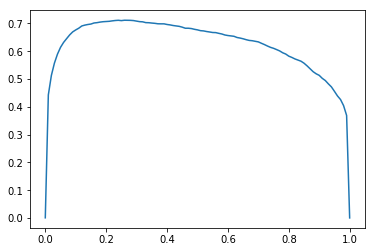

In [39]:
def calc_thres(output, target):
    it = np.arange(0, 1.01, 0.01)
    dice_thre = []
    for i in it:
        dice_thre.append(dice(target, output>i))
    print(dice_thre)
    return dice_thre
#     plt.plot(it, dice_thre)
#     plt.savefig()
#     threshold = dice_thre[np.argmax(dice_thre)]
        
# first uniform:

path = os.getcwd() + '/model/h5df_data/recon/'

for i in target:
    # i: binary
    threshold = np.zeros(101)
    for j in range(len(target[i])):
        # target[i][j]: binary, (shape), --
        threshold += calc_thres(weight[i][j]["data"][:], target[i][j]["data"][:])
    threshold /= len(target[i])
    plt.plot(np.arange(0, 1.01, 0.01), threshold)
    plt.savefig(path + i + '/weight_threashold.png')
    
    opt = threshold[np.argmax(threshold)]
    for j in range(len(target[i])):
        nib.save(nib.Nifti1Image(np.array(weight[i][j]["data"][:]>opt).astype(int), np.eye(4)), 
                 path + i + '/' + os.path.basename(target[i][j].filename) + "_weight_threashold.nii.gz")
for i in target:
    # i: binary
    threshold = np.zeros(101)
    for j in range(len(target[i])):
        # target[i][j]: binary, (shape), --
        threshold += calc_thres(uniform[i][j]["data"][:], target[i][j]["data"][:])
    threshold /= len(target[i])
    plt.plot(np.arange(0, 1.01, 0.01), threshold)
    plt.savefig(path + i + '/threashold.png')
    
    opt = threshold[np.argmax(threshold)]
    for j in range(len(target[i])):
        nib.save(nib.Nifti1Image(np.array(uniform[i][j]["data"][:]>opt).astype(int), np.eye(4)), 
                 path + i + '/' + os.path.basename(target[i][j].filename) + "_uniform_threashold.nii.gz")
    

In [27]:
for i in target:
    for j in range(len(target[i])):
        print(target[i][j])
        print(os.path.basename(target[i][j].filename))
    

<HDF5 file "(128, 256, 256)_target.h5" (mode r)>
(128, 256, 256)_target.h5


In [16]:
np.arange(0, 1.01, 0.01).shape
np.zeros(101).shape

(101,)

In [ ]:
plt.plot(it, dice_thre)
plt.savefig()
print(it[np.argmax(dice_thre)], dice_thre[np.argmax(dice_thre)])